#MNIST Multilayer Network - Brady Young
---



##Description

For this assignment, I added an additional layer to the existing perceptron network established in the first assignment. This "hidden" layer links the set of inputs to the set of output classifiers. This layer also allows the network to recognize the effect interdependence between inputs has on the output. While the single layer perceptron network classified numerals only based on the direct features of the input, the hidden layer can identify possible emergent features. 

Due to the varied structure of handwritten characters, there are multiple ways of drawing any one numeral. If a certain pixel is only present in 25% of a certain numerals feature set then that will lead to less weight towards that specific pixel, even though a quarter of the feature sets for that numeral contain it. However, when the pixel can be placed in relation to the rest of the pixels, weighted associations can be made between them. If the pixel that occured 25% of the time also had a "partner" pixel that only occured when it did, you can ignore all the feature sets that have the first pixel but not the second.

This advantage resulted in a higher classification accuracy than the perceptron network when it was applied to the same dataset. I have constructed several networks with various hyperparameter values in order to determine their effect on the network's performance.

---


## Modules

In [0]:
import numpy as np              #Used for array operations
import math                     #Used for exponent in sigmoid activation
import time                     #Used to benchmark training
import csv                      #Used for import dataset
import requests                 #Used to download dataset
import sys                      #Used to format printing
import os                       #Used to manage filesystem
import matplotlib.pyplot as plt #Used to plot data

##Data Acquistion, Preprocessing, and Plotting

###System

In [0]:
#Creates directory for writing data files
if(os.path.isdir('data') == False):
  os.makedirs('data')

###Remote Files

In [0]:
#Writes both training dataset and test dataset from
#remote location to local files

if(os.path.isfile('data/mnist_train.csv') == False):
  link = 'http://web.cecs.pdx.edu/~mm/MachineLearningWinter2019/mnist_train.csv'
  r = requests.get(link)
  with open('data/mnist_train.csv', 'wb') as file:
    file.write(r.content)
  
  link = 'http://web.cecs.pdx.edu/~mm/MachineLearningWinter2019/mnist_test.csv'
  r = requests.get(link)
  with open('data/mnist_test.csv', 'wb') as file:
      file.write(r.content)

### Reading in Data

In [0]:
#Copies the MNIST data into memory
trainset_in = []
testset_in = []

with open('data/mnist_train.csv', mode='r') as file:
  reader = csv.reader(file)
  for row in reader:
    trainset_in.append(row)
                
with open('data/mnist_test.csv', mode='r') as file:
  reader = csv.reader(file)
  for row in reader:
    testset_in.append(row)

### Dataset

In [0]:
#A wrapper to process the dataset after reading
class Dataset:
  def __init__(self):
    self.trainset = []
    self.testset = []
    self.goalset = []
    self.testgoalset = []
        
    for x in trainset_in:
      self.goalset.append(x.pop(0))               #Removes the goal from the list
      features = np.array(x, dtype = 'float64')   #Converts the list to ndarray
      features = features/255.0                   #Scales the inputs to [0,1]
      self.trainset.append(np.append(features, 1))#Add the list to the training set
                                                  #and the bias at the end
    for x in testset_in:
      self.testgoalset.append(x.pop(0))
      features = np.array(x, dtype = 'float64')
      features = features/255.0
      self.testset.append(np.append(features, 1))

# Instantiates the dataset
dataset = Dataset()

# Sets constant of output nodes
NUM_OUTPUT = len(set(dataset.testgoalset))

###Plotting

In [0]:
def plot(network):
  f = plt.figure(figsize=(25,6))
  ax1 = plt.subplot2grid((9, 5), (0, 0), colspan=5)
  ax2 = plt.subplot2grid((9, 5), (2, 0), colspan=3, rowspan=9)
  ax3 = plt.subplot2grid((9, 5), (2, 3), colspan=3, rowspan=9)
  
  
  ## Represents the characteristics of the specific network ##
  cellHeight = 0.4
  cellWidth = 0.2
  rowLabel = list(" ")
  colLabel = list(("Hidden Nodes", "Output Nodes", "Learning Rate", "Momentum", "Portion of Data"))
  
  tableData = np.array(list(((NUM_HIDDEN), (10), (RATE), (MOMENTUM), ("".join((str(PORTION*100), "%"))))), ndmin=2)
  
  tb = ax1.table(cellText=tableData, rowLabels=rowLabel, colLabels=colLabel, loc=(0,0), cellLoc='center')
  ax1.set_title("Network Attributes", y=1.08)
  tc = tb.properties()['child_artists']
  for cell in tc: 
    cell.set_height(cellHeight)
    cell.set_width(cellWidth)
  
  ax1.set_xticks([])
  ax1.set_yticks([])

  
  ## Network Accuracy ##
  ax2.set_title("Network Accuracy")
  x = list(range(NUM_EPOCHS))
  trainValues = np.array(network.trainResults).astype(np.float)
  testValues = np.array(network.testResults).astype(np.float)
      
  ax2.set_xlabel("Epoch")
  ax2.set_xlim(0, NUM_EPOCHS-1)
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim(0.8, 1)
  
  ax2.plot(x, trainValues, label='Training Acc.')
  ax2.plot(x, testValues, label='Test Acc.')


  trainAvg = "%.5f" % np.average(trainValues)
  testAvg = "%.5f" % np.average(testValues)
  
  ax2.annotate(s="Avg. Training Acc: " + str(trainAvg), xy=(25,0.81))
  ax2.annotate(s="Avg. Test Acc: " + str(testAvg), xy=(25,0.8))
  ax2.annotate(s="Final Training Acc: " + str(trainValues[NUM_EPOCHS-1]), xy=(40,0.81))
  ax2.annotate(s="Final Test Acc: " + str(testValues[NUM_EPOCHS-1]), xy=(40,0.8))
  
  
  ## Confusion Matrix representing error rates for individual digits ##
  cellHeight = 0.1
  cellWidth = 0.1
  rowLabel = list(range(10))
  colLabel = rowLabel
  colLabel.reverse()
  
  tb = ax3.table(cellText=network.confMat/50, rowLabels=rowLabel, colLabels=colLabel, loc=(0,0), cellLoc='center')
  ax3.set_title("Confusion Matrix", y=1.08)
  tc = tb.properties()['child_artists']
  for cell in tc: 
    cell.set_height(cellHeight)
    cell.set_width(cellWidth)
    
  ax3.set_xlabel("Target", labelpad = 5)
  ax3.set_ylabel("Output", labelpad = 5)
  ax3.set_xticks([])
  ax3.set_yticks([])

  
  plt.draw()
  plt.show()
  

## Network

### Math

In [0]:
# Sigmoid activation definition
def sigmoid(x):
  denom = 1 + math.exp(-x)
  return 1 / denom

### Nodes

In [0]:
## Class to hold the data members of subclasses ##
class Node:
  def __init__(self, num, inputs):
    self.weights = np.random.rand(num, inputs)
    self.weights -= 0.5    # Scales the weights
    self.activated = []    # List to hold activated values for each node
    self.error = None      # Holds the error value for each node
    self.prev = 0          # Holds the previous change to node weight


    
## Defines the node functions for the Hidden Layer ##
class Hidden(Node):
  
  # Creates a list of each hidden node's activated values
  def activation(self, array):
    self.activated = []
    for a in array:
      self.activated.append(sigmoid(a))
    self.activated.append(1)                    # attach bias
    self.activated = np.array(self.activated) 
    
  # Error calculation for hidden layer
  #  -Calculates each nodes error based on output node error and current activations
  #  -Sets the error for each node
  #  -Removes the bias from activated list and error list
  #    The bias is included up to the error calculation,
  #    but is removed afterwards because the bias node value
  #    will never be changed.
  def calcError(self, output):
    termTwo = (1 - self.activated)
    termThree = output.weights * output.error.reshape((-1,1))

    self.error = self.activated * termTwo * np.sum(termThree, axis=0)
    self.activated = np.delete(self.activated, NUM_HIDDEN)  # bias removed
    self.error = np.delete(self.error, NUM_HIDDEN)          # bias removed
   
  # Updates the weight values based on the error calculated, learning rate
  # the amount it previously changed by, and the momentum.
  def update(self, features):
    change = RATE * np.outer(self.error, features)
    self.weights += change + (MOMENTUM * self.prev)
    self.prev = change
    
    
    
## Defines the node functions for the output layer ##
class Output(Node):
  
  # Creates a list of each output node's activated values
  def activation(self, array):
    self.activated = []
    for a in array:
      self.activated.append(sigmoid(a))
    self.activated = np.array(self.activated)
  
  
  # Calculates error for output nodes
  def calcError(self, target):
    termTwo = (1 - self.activated)
    termThree = (target - self.activated)
    self.error = self.activated * termTwo * termThree
    
  # Updates the output node weights  
  def update(self, inputs):
    change = RATE * np.outer(self.error, inputs.activated)
    self.weights += change + (MOMENTUM * self.prev)
    self.prev = change

### Network

In [0]:
## Controls the network functions and data ##
class Network:
    def __init__(self):
      self.hidden = Hidden(NUM_HIDDEN, 785)
      self.output = Output(NUM_OUTPUT, NUM_HIDDEN+1)
      self.data = dataset
      
      self.trainResults = []      # Holds the results
      self.testResults = []       # for each epoch
      
      self.confMat = np.zeros((NUM_OUTPUT, NUM_OUTPUT))
    
    
    # Calls the training and testing functions
    # for each epoch and appends the results
    # to a list
    def run(self):
      start = time.clock()
      
      for i in range(NUM_EPOCHS):
        trainAcc = "%.5f" % self.train(i)     #store the resulting accuracies
        testAcc = "%.5f" % self.test(i)       #from training and testing
        
        print("\r", "Epoch: ", i,
              "Training Accuracy:", trainAcc, 
              "Testing Accuracy", testAcc, end="")
                          
        self.trainResults.append(trainAcc)
        self.testResults.append(testAcc)
        
      finish = time.clock() - start
      print("\nFinished in", "%.2f" % finish, "seconds.")
    
    
    # Iterates through the training set:
    #   -Feeds the data through the network
    #   -Updates the network weights
    # Returns the accuracy       
    def train(self, epoch):
      correct = 0.0
      iterations = 0.0
      
      # for each feature set in the training set v
      for i in range(int(len(self.data.trainset) * PORTION)):
        
        train = self.data.trainset[i]       # grab the featureset
        target = int(self.data.goalset[i])  # set the appropriate target class
        
        result = int(self.feed(train))      # feed the input through network
                                            # store the resulting output class
        if(result == target):
          correct += 1
        if(epoch != 0):                     # don't update values on first pass;
          self.backprop(target, train)      # establishes basis for test set
        iterations += 1
        
      return correct/iterations             # return the accuracy for that epoch
    
    
    # Iterates through the test set:
    #   -Feeds the data through the network
    #   -Updates the confusion matrix
    # Returns the accuracy
    def test(self, epoch):
      correct = 0.0
      iterations = 0.0
            
      for i in range(len(self.data.testset)):
        target = int(self.data.testgoalset[i])
        test = self.data.testset[i]     
        result = int(self.feed(test))
  
        if(result == target):
          correct += 1
        
        self.confMat[target][result] += 1     # update the confusion matrix
        iterations += 1
        
      return correct/iterations
    
    
    # Feeds the inputs through the network   
    def feed(self, inputs):
      # Hidden Layer #
      weights = self.hidden.weights * inputs     # multiply each weight by its associated input
      sums = np.sum(weights, axis=1)             # sum the weighted input values
      self.hidden.activation(sums)               # sets the hidden activation array 
                                                 # to activated values of summed weights   
      # Output Layer #  
      weights = self.output.weights * self.hidden.activated
      sums = np.sum(weights, axis=1)
      self.output.activation(sums)
     
      return np.argmax(self.output.activated)    # returns the index of largest value weight,
                                                 # which is the predicted class of input
      
    # Updates the network's weights by calculating error and propogating
    # the error backwards through the network    
    def backprop(self, target, features):
      targetArray = np.full(NUM_OUTPUT, 0.1)     # initializes array of target
      targetArray[target] = 0.9                  # values to 0.1, sets goal to 0.9                                    
      
      # Output Layer #
      self.output.calcError(targetArray)
      self.output.update(self.hidden)    
      
      # Hidden Layer #
      self.hidden.calcError(self.output)
      self.hidden.update(features)

## Execution and Results

### Varying Number of Hidden Nodes
The number of hidden nodes in the hidden layer directly affects the number of emergent (interdependant) features able to be recognized by the network. The more nodes in the layer, the more features can be correlated to certain classifications. Three networks were created with 10, 20, and 100 hidden nodes respectively. Each network runs for 50 epochs, has a learning rate of 0.1, and has a momentum of 0.9.

---

In [0]:
NUM_EPOCHS = 50
RATE = 0.1
MOMENTUM = 0.9
PORTION = 1

#### 10 Hidden Nodes

In [0]:
#@title  { output-height: 50 }
NUM_HIDDEN = 10
hidden10 = Network()
hidden10.run()

 Epoch:  49 Training Accuracy: 0.93528 Testing Accuracy 0.91460
Finished in 450.52 seconds.


##### Plot

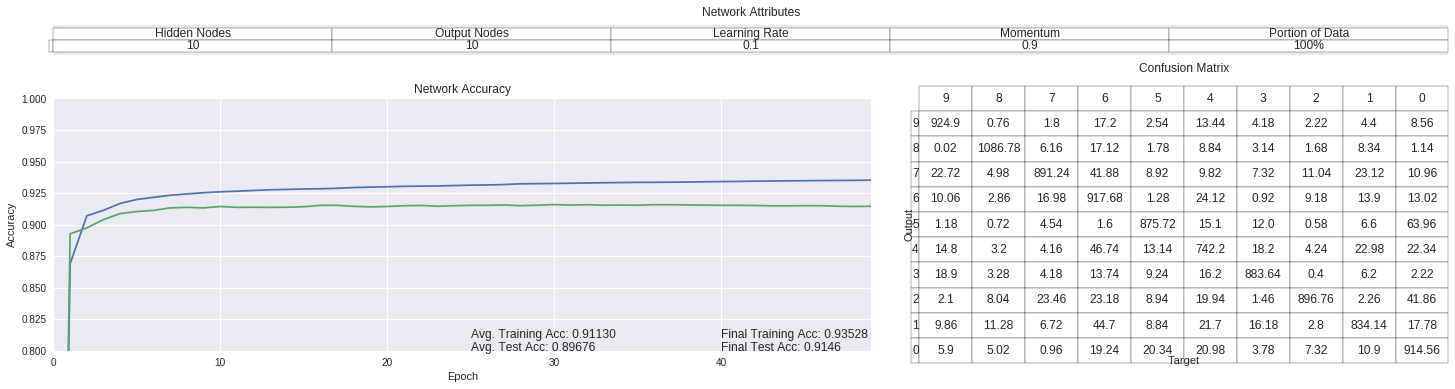

In [0]:
plot(hidden10)

#### 20 Hidden Nodes

In [0]:
#@title  { output-height: 50 }
NUM_HIDDEN = 20
hidden20 = Network()
hidden20.run()

 Epoch:  0 Training Accuracy: 0.08910 Testing Accuracy 0.09000

##### Plot

In [0]:
plot(hidden20)

#### 100 Hidden Nodes

In [0]:
#@title  { output-height: 50 }
NUM_HIDDEN = 100
hidden100 = Network()
hidden100.run()

##### Plot

In [0]:
plot(hidden100)

#### Summary

From my testing it seems that the number of hidden nodes in a multilayer network is positively associated with the overall accuracy of the network. With each increase in hidden node amount the accuracy on the test set increased by about 3%. However, the effect of each added node diminishes as the number of hidden nodes grows. While the first 3% increase only required a doubling from the previous test, the next 3% required an increase of 500% in order to show the same effect.

In regards to convergence, all the networks seemed to show the same amount of variance. 
If we assume that the network is converging towards the final accuracy value, then the difference between the final accuracy and the average can provide a rough estimate. However, all of the networks' average accuracies were 2% below the average, showing similar convergence.
If we assume that the network is converging towards 100% accuracy, then networks with higher amounts of hidden nodes converge to 100% in less epochs than networks with smaller amounts.

Each of the networks has overfit the data to some extent, as the accuracy on the test data is always less than the accuracy on the training data. 

Compared to the perceptron network, the accuracy of classification is much higher. The previous issue of misclassifying 9's is not a factor which has majorly increased accuracy. However, the addition of a hidden layer has affected the speed of training, with a larger hidden layer resulting in much longer processing times.

---


### Varying Momentum
The momentum parameter is used to scale the previous change to a weight in order to adjust the effect of previous changes. A higher momentum value reduces the frequency of weight changes resulting in oscillating weight values. I created three networks with varying momentum values and compared the accuracy of their output. Each network has 100 hidden nodes, runs for 50 epochs, and has a learning rate of 0.1.

---

In [0]:
NUM_EPOCHS = 50
NUM_HIDDEN = 100
RATE = 0.1
PORTION = 1

#### 0 Momentum

In [0]:
#@title  { output-height: 50 }
MOMENTUM = 0.0
zeroMom = Network()
zeroMom.run()

##### Plot

In [0]:
plot(zeroMom)

#### 0.5 Momentum

In [0]:
#@title  { output-height: 50 }
MOMENTUM = 0.5
halfMom = Network()
halfMom.run()

##### Plot

In [0]:
plot(halfMom)

  #### 0.9 Momentum

In [0]:
MOMENTUM = 0.9
plot(hidden100)

#### 1 Momentum

In [0]:
#@title  { output-height: 50 }
MOMENTUM = 1
oneMom = Network()
oneMom.run()

##### Plot

In [0]:
plot(oneMom)

#### Summary

Each of my networks had roughly identical accuracies, yet the averages reliably increased along with momentum value. 
The 
Networks with higher momentum values reinforce trends in the feature interactions and are more resistant to outlier effects.

---

### Varying Input Size
The network can only accurately classify features it has properly integrated. If a given set of feature interactions is absent from the training data, yet is present in the test data, the network will struggle to classify the numeral. With smaller datasets there is a lack of feature diversity which can yield biased output towards undocumented features in the test data.
Two networks were trained with subsets of the total training data, using a half and a quarter respectively. Each network runs for 50 epochs and has 100 hidden nodes,  a learning rate of 0.1, and a momentum of 0.9.


---


In [0]:
NUM_EPOCHS = 50
NUM_HIDDEN = 100
RATE = 0.1
MOMENTUM = 0.9

#### Half Dataset

In [0]:
#@title  { output-height: 50 }
PORTION = 0.5
half = Network()
half.run()

##### Plot

In [0]:
plot(half)

#### Quarter Dataset

In [0]:
#@title  { output-height: 50 }
PORTION = 0.25
quarter = Network()
quarter.run()

##### Plot

In [0]:
plot(quarter)

#### Summary

As the size of the dataset used for training decreases, the ability of the network to accurately classify the test set also decreases. Networks training on small amounts of data will overfit the training set more than a network with a larger training set. 

Convergence of the test accuracy with the training accuracy gets worse as the training set shrinks and less features in the test set are represented.